In [1]:
from Bio.Seq import Seq
from Bio import SeqIO
import numpy as np
from operator import itemgetter
import re
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

brown_repeats = ['TGGTGG','CCTCCCCT','TGGAG','AGGAG','CCCAG','GGGCT']
inverted_repeats_file = '/data/EBV/repeat_regions/inverted_positions_with_complemented.txt'
file_path = '/data/EBV/byACCIDs/NC_007605.fasta'
mapfile = '/data/EBV/msas/ids_171_ebv/ids_171_ebv_msa_gap1.51.fa_whole_mapping.file'
outpath = '/home/ariel/Projects/Gutierrez/EBV-recomb/recomb/rdp4_results/ids_171_ebv/10Miter/results/'
genbank_ref_file = '/data/EBV/byACCIDs/genBankRecord_NC_007605.gb'
whole_recom_rate = '/home/ariel/Projects/Gutierrez/EBV-recomb/recomb/rdp4_results/ids_171_ebv/10Miter/whole_10Miters.tsv'
gene_coords_file = '/data/EBV/by_gene/gene_result_lmp2.csv'

def get_items(d,keylist):
    return itemgetter(*keylist)(d)


def search_fasta(pattern, file_path):
    st = []
    end = []
    pat =[]
    reverse = str(Seq(pattern).reverse_complement())
    
    for patt in [pattern,reverse]:
        for record in SeqIO.parse(open(file_path, "rU"), "fasta"):
            chrom = record.id
            for match in re.finditer(patt, str(record.seq)):
                start_pos = match.start() + 1
                end_pos = match.end() + 1
                st.append(start_pos)
                end.append(end_pos)
                pat.append(patt)
    df = pd.DataFrame({'st':st,'end':end,'pattern':pat,'call':pattern})
    df = df[['st','end','pattern','call']]
    df.sort_values(by=['st'],inplace = True)
    
    return(df)


def compute_local_obs(rrate,r1,r2):
    return(rrate[r1:r2].apply(np.mean))


# requiere map_dict  (reference vs trimed aligment mapping)
# require rrate: dataframe containing stimated recombination rate in whole genome. Its index must be a trimed position. 
# this function require a dataframe indicating regions with two coordinates columns indicating position in reference genome!
# output: tuple (same dataframe plus mapped columns, rho series)
def mapp_and_compute_rho(df,start_col = 'st',end_col = 'end'):
    df = df.dropna(subset=[start_col,end_col])
    start_aux = [x if x in mapp_dict.keys() else (x +1 ) for x in df[start_col].values]
    end_aux = [x if x in mapp_dict.keys() else (x -1 ) for x in df[end_col].values]


    df['trimmed_st'] = get_items(mapp_dict,start_aux)
    df['trimmed_end'] = get_items(mapp_dict,end_aux)

    computed_rates = df.apply(lambda x: pd.concat([x,compute_local_obs(rrate,r1 = x.trimmed_st,r2 = x.trimmed_end)]),axis =1)
    return df,computed_rates



# this function allow us to extract complete list of features of each desidered region
#repeat_region = complete_features(tipo ='repeat_region' ,n=len(tipo))
#seq_record  must be a Sequence load from a genbank file

def complete_features(seq_record, TIPO='regulatory',n=5 ):
    ttyp = []
    loc = []
    get = []
    pos = []
    for feature in seq_record.features:
        ttyp.append(feature.type)

        if TIPO[0:n] in feature.type:
            get.append({k: feature.qualifiers[k][0] for k in feature.qualifiers.keys()})

            partes = []
            for p in feature.location.parts:
                partes.append(pd.Series([p.start.position,p.end.position]))
            positions = pd.concat(partes,1).transpose()    
            positions.columns = ['start','end']
            pos.append(positions)        #print feature

    get = pd.DataFrame(get)        
    pos = pd.concat(pos)

#    return(get,pos)

    pos.index = get.index
    get_features = pd.concat([get,pos],1)
        
    return(get_features)


def pos_to_trim(p):
    if type(p) in [int,float,numpy.int64] :
        tr = [x if x in mapp_dict.keys() else (x -1 ) for x in [p]]
    else:
        tr = [x if x in mapp_dict.keys() else (x -1 ) for x in p]
    return(get_items(mapp_dict,tr))


####### map for all downstream analysis####
###########################################
mapp = pd.read_csv(mapfile,sep = '|')
mapp_dict = mapp[['refCoord','trimmedCoord']]

rrate = pd.read_csv(whole_recom_rate,sep = '|')
rrate.set_index(['trimmed_position'],inplace = True)

mapp_dict =  {}
refcoords = mapp.loc[:,'refCoord']
trimcoords = mapp.loc[:,'trimmedCoord']
for i in range(mapp.shape[0]):
    mapp_dict.update({refcoords[i]:trimcoords[i]})


    
def look_for_gene(position,gene_coords):
    res = gene_coords[(position> gene_coords.start_position_on_the_genomic_accession) & (position<gene_coords.end_position_on_the_genomic_accession)]
    m = res[['Symbol','gen_len']].drop_duplicates()
    m.sort_values(by=['gen_len'],ascending = True)
    if m.shape[0]>0:
        return(m.Symbol[0])
    else:
        return('intr')
    

In [2]:
#df provide start- end positions
def compute_gap(df,start_col='st',end_col='end',window = 200):
    mmax = mapp.refCoord.max()
    col ='Mean Rho/bp.'
    start_aux = [x if x in mapp_dict.keys() else (x +1 ) for x in df[start_col].values]
    end_aux = [x if x in mapp_dict.keys() else (x -1 ) for x  in df[end_col].values]
    trimmed_start = get_items(mapp_dict,start_aux)
    trimmed_end = get_items(mapp_dict,end_aux)

    start_gap = [x-window if x-window in mapp_dict.keys() else (x -window +1 ) for x in df[start_col].values]
    end_gap = [x +window if x+window in mapp_dict.keys() else (x +window -1 ) for x in df[end_col].values]
    end_gap = [x if (x <= mmax) else mmax for x in end_gap]
    
    trimmed_start_gap = get_items(mapp_dict,start_gap)
    trimmed_end_gap = get_items(mapp_dict,end_gap)
    
    
    df['trimmed_st'] = trimmed_start
    df['trimmed_end'] = trimmed_end

    df['trimmed_st_gap'] = trimmed_start_gap
    df['trimmed_end_gap'] = trimmed_end_gap

    rate_prev = df.apply(lambda x: pd.concat([x,compute_local_obs(rrate,r1 = x.trimmed_st_gap,r2 = x.trimmed_st)]),axis =1)
    rate_post = df.apply(lambda x: pd.concat([x,compute_local_obs(rrate,r1 = x.trimmed_end,r2 = x.trimmed_end_gap)]),axis =1)
    
    
    return(pd.merge(rate_prev[[start_col,end_col,'call',col]],rate_post[col].to_frame(),right_index = True,
                    left_index = True,suffixes=['_left','_right']))
    
    #rate_prev[col].fillna(0,inplace = True)
    #rate_post[col].fillna(0,inplace = True)
    #rate_prev['diff'] = rate_prev[col]-rate_post[col]
    #rate_prev['gap_perc'] = (rate_post[col]-rate_prev[col])/np.min([rate_prev[col],rate_post[col]])
    
    #return(rate_prev[[start_col,end_col,'call','']])
    
    #:pos_to_trim(repeat_postions.end[0])]

In [47]:
%matplotlib inline

print 'analyzing Brown motifs'
positions = {}
for br_rep in brown_repeats:
    df = search_fasta(br_rep,file_path)
    positions.update({br_rep:df})
    
repeat_postions = pd.concat(positions)


####### compute gaps (jumps) arround brown motifs
gaps = compute_gap(repeat_postions,window=10)
gaps2 = gaps.copy()
mmin = gaps[['Mean Rho/bp._left','Mean Rho/bp._right']].apply(lambda x: np.nanmin(x)).min()
gaps2['Mean Rho/bp._left'].fillna(mmin,inplace = True)
gaps2['Mean Rho/bp._right'].fillna(mmin,inplace = True)

gaps2['diff'] =gaps2['Mean Rho/bp._right']-gaps2['Mean Rho/bp._left']

gaps2['gap'] =gaps2.apply(lambda x:
                          (x['Mean Rho/bp._right']-x['Mean Rho/bp._left'])/np.min([x['Mean Rho/bp._right'],x['Mean Rho/bp._left']]),1)



analyzing Brown motifs


In [4]:
#gaps2[(gaps2.st>70000)&(gaps2.gap>500)]

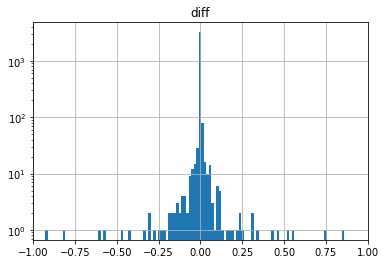

In [4]:
gaps2[['diff']].hist(bins = 500)
plt.xlim([-1,1])
plt.yscale('log')
#plt.xscale('symlog')

In [5]:
### prepare random 5 mers
kmer = 5
rand_gap_windows = 10
np.random.seed(123)
rand = np.random.choice(np.arange(mapp.refCoord.max()-(2*rand_gap_windows+2))+rand_gap_windows,1000,replace=False)
rand.sort()

rand_df = pd.DataFrame({'st':rand,'end':rand+kmer})
rand_df['call'] = 'random'


## get a null hipotesys for those gaps
randgaps = compute_gap(rand_df,window = rand_gap_windows)
randgaps2 = randgaps.copy()
mmin = randgaps[['Mean Rho/bp._left','Mean Rho/bp._right']].apply(lambda x: np.nanmin(x)).min()
randgaps2['Mean Rho/bp._left'].fillna(mmin,inplace = True)
randgaps2['Mean Rho/bp._right'].fillna(mmin,inplace = True)

randgaps2['diff'] =randgaps2['Mean Rho/bp._right']-randgaps2['Mean Rho/bp._left']

randgaps2['gap'] =randgaps2.apply(lambda x:
                          (x['Mean Rho/bp._right']-x['Mean Rho/bp._left'])/np.min([x['Mean Rho/bp._right'],x['Mean Rho/bp._left']]),1)



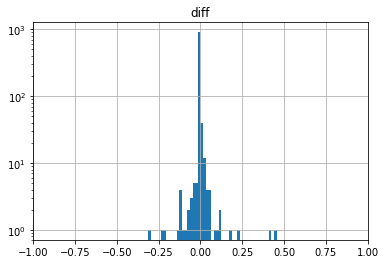

In [6]:
randgaps2[['diff']].hist(bins = 500)

plt.xlim([-1,1])
plt.yscale('log')

In [7]:
gene_coords = pd.read_csv(gene_coords_file,sep = '\t')
gene_coords['gen_len']= gene_coords['end_position_on_the_genomic_accession'] - gene_coords['start_position_on_the_genomic_accession']

gene_ref_coords = gene_coords[['GeneID','Symbol','Aliases','start_position_on_the_genomic_accession','end_position_on_the_genomic_accession','gen_len']]
gene_ref_coords['rang'] = gene_coords.apply(lambda x: (x.start_position_on_the_genomic_accession,
                                                   x.end_position_on_the_genomic_accession),1)
gene_ref_coords.set_index(['rang'],inplace = True)

gaps3 = gaps2.reset_index()
gen_st =gaps3.st.apply(lambda x:np.unique([look_for_gene(position=x,gene_coords=gene_ref_coords[gene_ref_coords.Symbol!='LMP2'])]))
gen_end =gaps3.end.apply(lambda x:np.unique([look_for_gene(position=x,gene_coords=gene_ref_coords[gene_ref_coords.Symbol!='LMP2'])]))


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
gene_ref_coords.head()

,GeneID,Symbol,Aliases,start_position_on_the_genomic_accession,end_position_on_the_genomic_accession,gen_len
rang,,,,,,
"(155549.0, 160531.0)",3783676,A73,HHV4_A73,155549.0,160531.0,4982.0
"(164388.0, 165255.0)",3783677,BALF1,NaN,164388.0,165255.0,867.0
"(160550.0, 164356.0)",3783678,BALF2,HHV4_BALF2,160550.0,164356.0,3806.0
"(164979.0, 164984.0)",17494228,BALF2,NaN,164979.0,164984.0,5.0
"(158851.0, 161220.0)",3783679,BALF3,NaN,158851.0,161220.0,2369.0


In [8]:
### check orientation
gene_coords = pd.read_csv(gene_coords_file,sep = '\t')
gene_coords['gen_len']= gene_coords['end_position_on_the_genomic_accession'] - gene_coords['start_position_on_the_genomic_accession']

gene_ref_coords = gene_coords[['GeneID','Symbol','Aliases','start_position_on_the_genomic_accession','end_position_on_the_genomic_accession','gen_len']]
gene_ref_coords['rang'] = gene_coords.apply(lambda x: (x.start_position_on_the_genomic_accession,
                                                   x.end_position_on_the_genomic_accession),1)
gene_ref_coords.set_index(['rang'],inplace = True)

gaps3 = gaps2.reset_index()
#gene =  gaps3.st.apply(lambda x:look_for_gene(position=x,gene_coords=gene_ref_coords[gene_ref_coords.Symbol!='LMP2']))
gene =  gaps3.st.apply(lambda x:look_for_gene(position=x,gene_coords=gene_ref_coords))

gaps3['GENE'] = gene
rep_with_gene = gaps3.copy()

#rep_with_gene.GENE.replace({'intr':'LMP2'},inplace = True)

rep_with_gene_orient = pd.merge(rep_with_gene,gene_coords[['Symbol','orientation']],left_on=['GENE'],right_on='Symbol',how = 'left').drop(['Symbol'],1)
rep_with_gene_plus = rep_with_gene_orient[rep_with_gene_orient.orientation == 'plus']
rep_with_gene_minus = rep_with_gene_orient[rep_with_gene_orient.orientation == 'minus']
rep_with_gene_intron = rep_with_gene_orient[rep_with_gene_orient.orientation.isnull()]
                                   

  

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [9]:
right_tresh = randgaps2[['gap']].quantile(0.975)['gap']
left_tresh = randgaps2[['gap']].quantile(0.025)['gap']

  
initiators_PLUS = rep_with_gene_plus[rep_with_gene_plus.gap>right_tresh][['st','end','call','Mean Rho/bp._left','Mean Rho/bp._right','GENE','orientation']]#.value_counts().sort_index()#/rep_with_gene_plus['call'].value_counts()
initiators_MINUS = rep_with_gene_minus[rep_with_gene_minus.gap<left_tresh][['st','end','call','Mean Rho/bp._left','Mean Rho/bp._right','GENE','orientation']]#.value_counts()#/rep_with_gene_plus['call'].value_counts()


print right_tresh
print left_tresh

471.325
-594.85014881


In [10]:
rep_with_gene_plus[rep_with_gene_plus.gap>right_tresh].head(15)

,level_0,level_1,st,end,call,Mean Rho/bp._left,Mean Rho/bp._right,diff,gap,GENE,orientation
9,AGGAG,3,1968,1973,AGGAG,0.00001,0.026575,0.026565,2656.500000,BNRF1,plus
723,AGGAG,125,66136,66141,AGGAG,0.00001,0.114364,0.114354,11435.375000,BORF2,plus
725,AGGAG,580,67091,67096,AGGAG,0.00001,0.012469,0.012459,1245.888889,BaRF1,plus
726,AGGAG,580,67091,67096,AGGAG,0.00001,0.012469,0.012459,1245.888889,BaRF1,plus
741,AGGAG,130,69452,69457,AGGAG,0.00001,0.249380,0.249370,24937.000000,BMRF2,plus
1220,AGGAG,714,156444,156449,AGGAG,0.00001,0.008720,0.008710,871.000000,A73,plus
1327,CCCAG,2,3077,3082,CCCAG,0.00001,0.005463,0.005453,545.250000,BNRF1,plus
2920,CCCAG,779,67377,67382,CCCAG,0.00001,0.035119,0.035109,3510.866667,BaRF1,plus
2921,CCCAG,779,67377,67382,CCCAG,0.00001,0.035119,0.035109,3510.866667,BaRF1,plus
2929,CCCAG,782,68215,68220,CCCAG,0.00001,0.037470,0.037460,3746.000000,BMRF1,plus


In [11]:
print (rep_with_gene_plus.gap>right_tresh).sum()/float(rep_with_gene_plus.shape[0])
print (rep_with_gene_minus.gap<left_tresh).sum()/float(rep_with_gene_minus.shape[0])


0.00897744690169
0.0226077812829


In [13]:
print initiators_MINUS.shape
print initiators_PLUS.shape

(43, 7)
(41, 7)


In [14]:
from scipy import stats
np.random.seed(12345678)
x = stats.norm.rvs(loc=5, scale=3, size=1000)
print stats.shapiro(x)
print stats.shapiro(initiators_PLUS['Mean Rho/bp._right'].values)

(0.9987979531288147, 0.753572940826416)
(0.6376484632492065, 8.014291452695943e-09)


In [58]:
## cuardo coordenadas de iniciadores
mapa = repeat_postions[['st','end','trimmed_st','trimmed_end']]
plus_to_save = pd.merge(initiators_PLUS,mapa.drop(['end'],axis = 1),how = 'left',on= 'st')
minus_to_save = pd.merge(initiators_MINUS,mapa.drop(['end'],axis = 1),how = 'left',on= 'st')

plus_to_save.to_csv(outpath+'initiator_plus_trimmed_coords.csv',index = False)
minus_to_save.to_csv(outpath+'initiator_minus_trimmed_coords.csv',index = False)

(41, 9)


In [15]:
from scipy.stats  import mannwhitneyu as mwu
from scipy.stats  import ranksums as rks

initiators_MINUS['Mean Rho/bp._left'].mean()
initiators_PLUS['Mean Rho/bp._right'].mean()
x=initiators_MINUS['Mean Rho/bp._left'].values
y=initiators_PLUS['Mean Rho/bp._right'].values
print mwu(x,y)
print stats.ks_2samp(x,y)
import scipy.stats.mstats
print scipy.stats.mstats.ks_twosamp(x,y, alternative='greater')

MannwhitneyuResult(statistic=742.0, pvalue=0.10648644076810881)
Ks_2sampResult(statistic=0.2263187748156551, pvalue=0.20286311920439667)
(0.22631877481565504, 0.11648085424241379)


In [16]:
from scipy.stats  import mannwhitneyu as mwu
from scipy.stats  import ranksums as rks

initiators_MINUS['Mean Rho/bp._left'].mean()
initiators_PLUS['Mean Rho/bp._right'].mean()
x=initiators_MINUS['Mean Rho/bp._left'].values
y=initiators_PLUS['Mean Rho/bp._right'].values
print mwu(x,y)
print stats.ks_2samp(x,y)
import scipy.stats.mstats
print scipy.stats.mstats.ks_twosamp(x,y, alternative='greater')

MannwhitneyuResult(statistic=742.0, pvalue=0.10648644076810881)
Ks_2sampResult(statistic=0.2263187748156551, pvalue=0.20286311920439667)
(0.22631877481565504, 0.11648085424241379)


In [17]:
initiators_MINUS.drop_duplicates(inplace = True)
init_minus_bubble = initiators_MINUS.groupby(['GENE','call'])['Mean Rho/bp._left'].mean().to_frame()
#init_minus_bubble.to_csv(outpath+'initiators_minus_wind10_LMP2.csv')


initiators_PLUS.drop_duplicates(inplace = True)
initiators_PLUS = initiators_PLUS[initiators_PLUS['Mean Rho/bp._right']<1]
init_plus_bubble = initiators_PLUS.groupby(['GENE','call'])['Mean Rho/bp._right'].mean().to_frame()
#init_plus_bubble.to_csv(outpath+'initiators_plus_wind10_LMP2.csv')

In [31]:
(initiators_MINUS.call.value_counts()+initiators_PLUS.call.value_counts()).sort_values()

TGGTGG     5
AGGAG      9
GGGCT     14
TGGAG     18
CCCAG     20
Name: call, dtype: int64

In [48]:
# for log scale
#df = pd.concat([initiators_MINUS.call.value_counts(), initiators_PLUS.call.value_counts()],1).sum(1).apply(lambda x: np.log2(x))
df = pd.concat([initiators_MINUS.call.value_counts(), initiators_PLUS.call.value_counts()],1).sum(1)
df.sort_values(inplace=True,ascending = False)

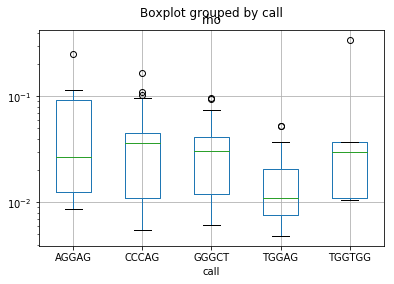

In [49]:
aux2 = pd.concat([initiators_MINUS.rename(columns={'Mean Rho/bp._left':'rho'}),initiators_PLUS.rename(columns={'Mean Rho/bp._right':'rho'})])
aux2.boxplot(by ='call',column='rho')
plt.yscale('log')

In [50]:
motifss = {}
for cat in aux2.call:
    motifss.update({cat:aux2[aux2.call==cat].rho})


In [51]:
motifss.keys()

['CCCAG', 'GGGCT', 'AGGAG', 'TGGAG', 'TGGTGG']

In [52]:
aux = pd.concat([initiators_MINUS[['GENE','call']],initiators_PLUS[['GENE','call']]])
print aux[aux.call=='TGGAG'].GENE.nunique()
print aux[aux.call=='CCCAG'].GENE.nunique()

13
16


In [53]:
pd.concat([initiators_MINUS.call.value_counts(), initiators_PLUS.call.value_counts()],1).sum(1)
#.apply(lambda x: np.log2(x))

AGGAG      9
CCCAG     20
GGGCT     14
TGGAG     18
TGGTGG     5
dtype: int64

## antes de modificar lmp2

In [83]:

#pd.concat([initiators_MINUS.call.value_counts(), initiators_PLUS.call.value_counts()],1).sum(1)
#.apply(lambda x: np.log2(x))

AGGAG       13.0
CCCAG       21.0
CCTCCCCT     1.0
GGGCT       18.0
TGGAG       23.0
TGGTGG       6.0
dtype: float64

In [72]:
import gact
import matplotlib.pyplot as plt
import gact


def draw_logo(score_list):
    fig, ax = plt.subplots(figsize=(5,3))

    all_scores = score_list

    x = 1
    maxi = 0
    for scores in all_scores:
        y = 0
        for base, score in scores:
            gact.letterAt(base, x,y, score, ax)
            y += score
        x += 1
        maxi = max(maxi, y)

    plt.xticks(range(1,x))
    plt.xlim((0, x)) 
    plt.ylim((0, maxi)) 
    plt.yticks([1,5,10,15,20],[1,5,10,15,20])
    plt.tight_layout()      


In [73]:
to_plot = []
for i in range(df.shape[0]):
    r = df.index[i]
    score = (df.values[i]/float(len(r)))
    motif = []
    for s in r:
        motif.append((s,score))
    to_plot.append(motif)


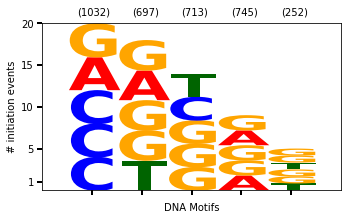

In [75]:
draw_logo(to_plot)

plt.ylabel('# initiation events')
plt.xlabel('DNA Motifs')
x = np.arange(len(to_plot))+1
plt.tick_params(width=2,length = 5,axis = 'both')
plt.xticks(x, "", rotation='vertical')

yy=21
plt.text(x=0.7,y=yy,s='(1032)')
plt.text(x=1.8,y=yy,s='(697)')
plt.text(x=2.8,y=yy,s='(713)')
plt.text(x=3.8,y=yy,s='(745)')
plt.text(x=4.8,y=yy,s='(252)')
plt.tight_layout()

plt.savefig(outpath+'motif_logo'+'.png',dpi = 400)

In [46]:
initiators_PLUS.head()

,st,end,call,Mean Rho/bp._left,Mean Rho/bp._right,GENE,orientation
9,1968,1973,AGGAG,0.00001,0.026575,BNRF1,plus
723,66136,66141,AGGAG,0.00001,0.114364,BORF2,plus
725,67091,67096,AGGAG,0.00001,0.012469,BaRF1,plus
741,69452,69457,AGGAG,0.00001,0.249380,BMRF2,plus
1220,156444,156449,AGGAG,0.00001,0.008720,A73,plus


In [47]:
motif_gene_dict = {}
for mot in df.index:
    gene_plus = initiators_PLUS[initiators_PLUS.call==mot].GENE
    gene_minus = initiators_MINUS[initiators_MINUS.call==mot].GENE
    motif_gene_dict.update({mot:pd.concat([gene_plus,gene_minus]).unique()})

In [49]:
import pickle
with open(outpath+'motif_gene_dict.pickle', 'wb') as handle:
    pickle.dump(motif_gene_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [50]:
outpath

'/home/ariel/Projects/Gutierrez/EBV-recomb/recomb/rdp4_results/ids_171_ebv/10Miter/results/'